# Introduction to Compartmental Models

Compartmental models in epidemiology are used to model the spread of infectious diseases by dividing the population into compartments based on disease status. These models help in understanding how diseases spread and assessing the impact of interventions.

## The SIR Model

The SIR model can be described by the following set of differential equations:

- $\frac{dS}{dt} = -\frac{\beta I S}{N}$
- $\frac{dI}{dt} = \frac{\beta I S}{N} - \gamma I$
- $\frac{dR}{dt} = \gamma I$

where \(N\) is the total population.

These equations represent the rate of change over time for each compartment in the model:

- $S$ represents the number of susceptible individuals,
- $I$ represents the number of infected individuals,
- $R$ represents the number of recovered individuals.

The parameter $\beta$ represents the transmission rate, which affects how quickly the disease spreads from infected to susceptible individuals, while $\gamma$ represents the recovery rate, indicating the fraction of infected individuals who recover from the disease each day.


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint


In [4]:
# SIR model differential equations.
def sir_model(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt


In [5]:
# Total population, N.
N = 1000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.3, 0.1
# A grid of time points (in days)
t = np.linspace(0, 160, 160)

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(sir_model, y0, t, args=(N, beta, gamma))
S, I, R = ret.T


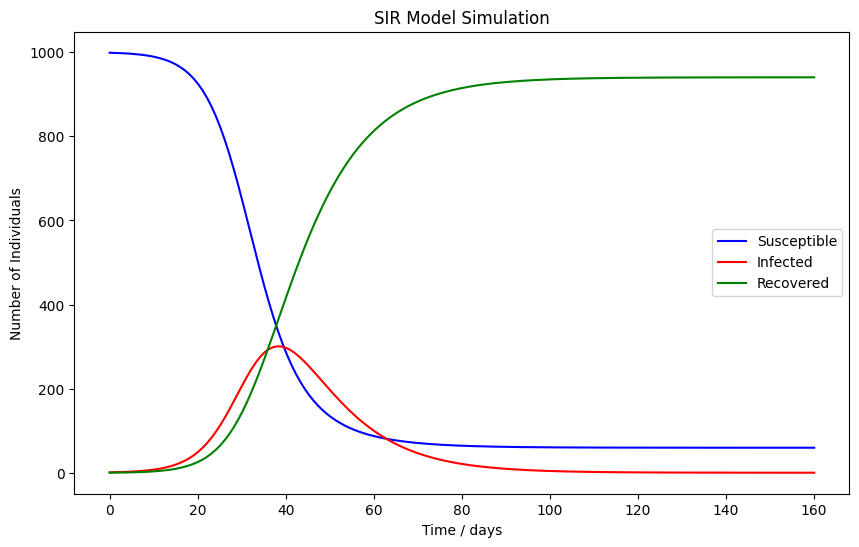

In [6]:
# Plotting
plt.figure(figsize=(10,6))
plt.plot(t, S, 'b', label='Susceptible')
plt.plot(t, I, 'r', label='Infected')
plt.plot(t, R, 'g', label='Recovered')
plt.title('SIR Model Simulation')
plt.xlabel('Time / days')
plt.ylabel('Number of Individuals')
plt.legend()
plt.show()

## Extending the SIR Model to Include Spatial Dynamics

After understanding the basic dynamics of the SIR model, we can extend it to incorporate spatial aspects. This involves considering multiple regions or compartments, each with its own SIR dynamics, and allowing for interaction between these regions to model the spread of an infectious disease across space.

### Spatial Model Concept

In the spatial SIR model, we divide the total population into several regions or compartments. Each compartment has its own susceptible ($S$), infected ($I$), and recovered ($R$) populations, and the disease can spread within and between these compartments. This approach allows us to model not just the spread of disease over time but also its spread across different geographical areas or populations.

### Incorporating Spatial Dynamics into the SIR Model

To incorporate spatial dynamics, we use the same basic differential equations from the SIR model for each region but add terms to represent the movement or interaction between regions.

## SIR model in two regions

In [11]:
import numpy as np
from scipy.integrate import odeint

# Extended SIR model for spatial dynamics with two regions
def extended_sir_model(y, t, N, beta, gamma, m):
    # Unpack the current states for both regions
    S1, I1, R1, S2, I2, R2 = y
    
    # Total population for each region
    N1, N2 = N
    
    # Effective contact rates and recovery rates
    beta1, beta2 = beta
    gamma1, gamma2 = gamma
    
    # Mobility rate (m) represents the rate of movement between regions
    
    # Differential equations for region 1
    dS1dt = -beta1 * S1 * I1 / N1 + m * (S2 - S1)
    dI1dt = beta1 * S1 * I1 / N1 - gamma1 * I1 + m * (I2 - I1)
    dR1dt = gamma1 * I1 + m * (R2 - R1)
    
    # Differential equations for region 2
    dS2dt = -beta2 * S2 * I2 / N2 + m * (S1 - S2)
    dI2dt = beta2 * S2 * I2 / N2 - gamma2 * I2 + m * (I1 - I2)
    dR2dt = gamma2 * I2 + m * (R1 - R2)
    
    # Return the derivatives for both regions
    return dS1dt, dI1dt, dR1dt, dS2dt, dI2dt, dR2dt

In [12]:
# Example usage
N = [1000, 500]  # Population sizes for two regions
beta = [0.2, 0.2]  # Transmission rates for two regions
gamma = [0.1, 0.1]  # Recovery rates for two regions
m = 0.05  # Mobility rate between the two regions

# Initial conditions: S1, I1, R1, S2, I2, R2
y0 = [999, 1, 0, 500, 0, 0]  # One infected in region 1, none in region 2

t = np.linspace(0, 100, 1000)  # Time grid

# Solve the differential equations
sol = odeint(extended_sir_model, y0, t, args=(N, beta, gamma, m))


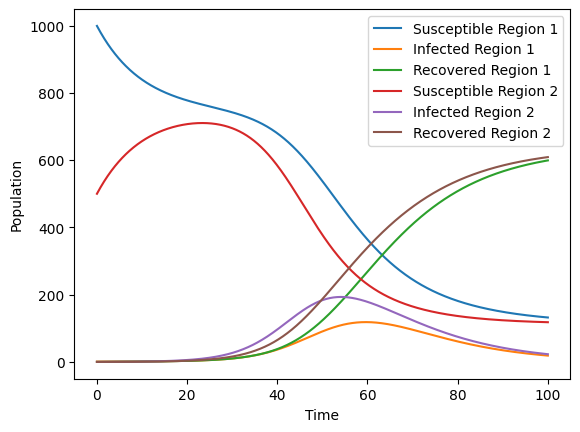

In [13]:
plt.plot(t, sol[:, 0], label='Susceptible Region 1')
plt.plot(t, sol[:, 1], label='Infected Region 1')
plt.plot(t, sol[:, 2], label='Recovered Region 1')
plt.plot(t, sol[:, 3], label='Susceptible Region 2')
plt.plot(t, sol[:, 4], label='Infected Region 2')
plt.plot(t, sol[:, 5], label='Recovered Region 2')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()

## generic SIR model for any number of regions

In [14]:
def generic_spatial_sir(y, t, N, beta, gamma, M):
    """
    A generic spatial SIR model for any number of regions.
    
    Parameters:
    - y: Initial state vector for all regions [S1, I1, R1, S2, I2, R2, ..., SN, IN, RN].
    - t: Time array for the simulation.
    - N: Array of population sizes for each region.
    - beta: Transmission rate for each region.
    - gamma: Recovery rate for each region.
    - M: Mobility matrix representing movement between regions (NxN matrix).
    
    Returns:
    - The derivatives (dSdt, dIdt, dRdt) for all regions.
    """
    
    num_regions = len(N)
    derivatives = np.zeros(num_regions * 3) # Initialize derivatives vector
    
    for i in range(num_regions):
        S, I, R = y[i*3:(i+1)*3] # Extract S, I, R for region i
        
        # Calculate net movement for susceptible and infected individuals
        net_S_movement = sum(M[j][i] * y[j*3] - M[i][j] * S for j in range(num_regions))
        net_I_movement = sum(M[j][i] * y[j*3+1] - M[i][j] * I for j in range(num_regions))
        
        # SIR model equations with mobility
        dSdt = -beta[i] * S * I / N[i] + net_S_movement
        dIdt = beta[i] * S * I / N[i] - gamma[i] * I + net_I_movement
        dRdt = gamma[i] * I
        
        # Update derivatives
        derivatives[i*3:(i+1)*3] = [dSdt, dIdt, dRdt]
    
    return derivatives

In [17]:
# Example usage for 3 regions
N = [1000, 800, 1200]  # Population sizes
beta = [0.2, 0.1, 0.3]  # Transmission rates
gamma = [0.1, 0.05, 0.15]  # Recovery rates
M = np.array([[0, 0.01, 0.02],  # Mobility matrix
              [0.01, 0, 0.01],
              [0.02, 0.01, 0]])

# Initial conditions [S1, I1, R1, S2, I2, R2, S3, I3, R3]
y0 = [999, 1, 0, 800, 0, 0, 1200, 0, 0]

t = np.linspace(0, 200, 1000)  # Time grid

# Solve the differential equations
sol = odeint(generic_spatial_sir, y0, t, args=(N, beta, gamma, M))

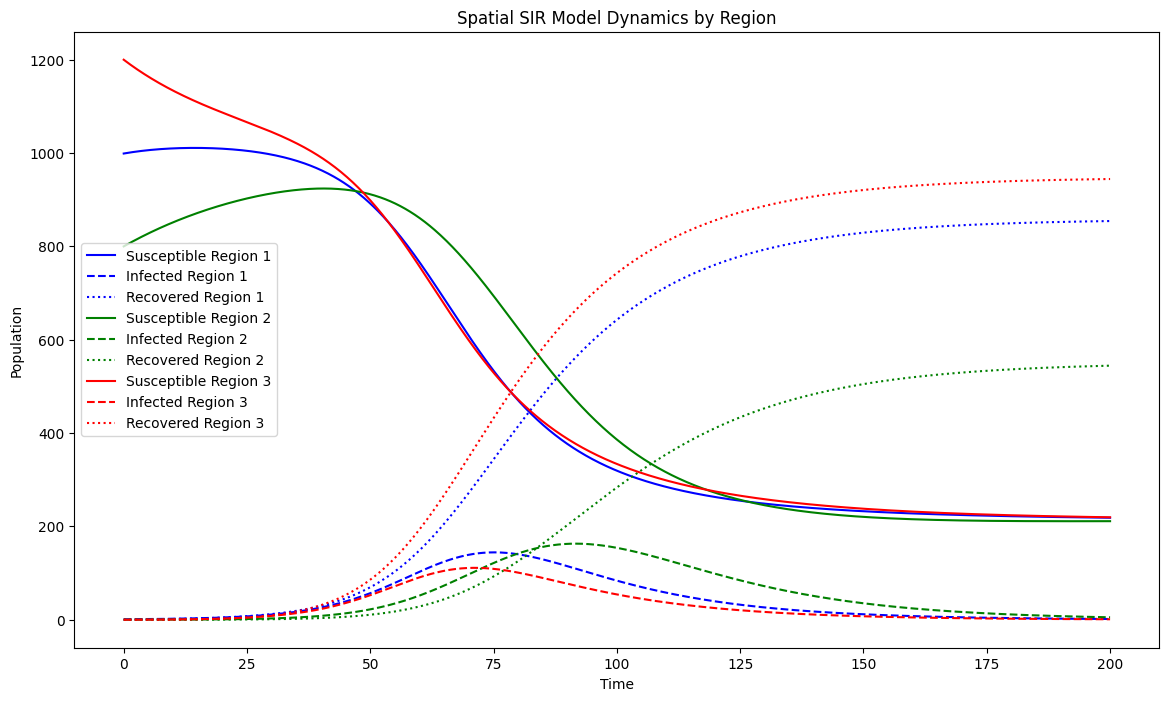

In [19]:
# Define colors for each region
colors = ['blue', 'green', 'red']  # Add more colors if you have more than 3 regions

# Define line styles for S, I, R populations
line_styles = ['-', '--', ':']  # solid, dashed, dotted

plt.figure(figsize=(14, 8))

for i in range(len(N)):
    # Plot susceptible population for region i
    plt.plot(t, sol[:, i*3], label=f'Susceptible Region {i+1}', color=colors[i], linestyle=line_styles[0])
    # Plot infected population for region i
    plt.plot(t, sol[:, i*3+1], label=f'Infected Region {i+1}', color=colors[i], linestyle=line_styles[1])
    # Plot recovered population for region i
    plt.plot(t, sol[:, i*3+2], label=f'Recovered Region {i+1}', color=colors[i], linestyle=line_styles[2])

plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Spatial SIR Model Dynamics by Region')
plt.legend()
plt.show()
